In [1]:
from collab_filtering import NeuralCollabFiltering
import pandas as pd
import time

In [2]:
csv_path = '../summit_recommender/dataset/spot_scid_slug_20200301-20200831.csv'
df = pd.read_csv(csv_path)
# df.head()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284982 entries, 0 to 3284981
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   summit_client_id  object 
 1   slug              object 
 2   time_on_page      float64
 3   published_date    object 
dtypes: float64(1), object(3)
memory usage: 100.2+ MB


In [4]:
df.summit_client_id.unique().shape, df.slug.unique().shape

((2404362,), (17538,))

## Reduce and Clean

In [5]:
users = df['summit_client_id'].value_counts()
items = df['slug'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('users\n', users.quantile(quantiles))
print('items\n', items.quantile(quantiles))

users
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       1.0
0.90       2.0
0.95       3.0
0.96       3.0
0.97       3.0
0.98       4.0
0.99       6.0
1.00    1855.0
Name: summit_client_id, dtype: float64
items
 0.00         1.00
0.01         1.00
0.02         1.00
0.03         1.00
0.04         1.00
0.05         1.00
0.10         1.00
0.25         2.00
0.50         5.00
0.75        29.00
0.90       211.00
0.95       590.15
0.96       776.60
0.97      1158.56
0.98      1926.04
0.99      3870.47
1.00    109323.00
Name: slug, dtype: float64


This tells us that only 10% of users have viewed atleast 2 articles and 75% of articles have atleast 2 views.
We will reduce the data to remove the tails by selecting users who have read atleast 2 articles and articles that are also read twice.

In [6]:
users = users[users >= 2]
items = items[items >= 2]

reduced_df = df.merge(pd.DataFrame({'summit_client_id': users.index})).merge(pd.DataFrame({'slug': items.index}))

In [7]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243195 entries, 0 to 1243194
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   summit_client_id  1243195 non-null  object 
 1   slug              1243195 non-null  object 
 2   time_on_page      1243195 non-null  float64
 3   published_date    1243195 non-null  object 
dtypes: float64(1), object(3)
memory usage: 47.4+ MB


From 3.2 million records, the new dataset is reduced to 1.2 million records.

In [8]:
reduced_df.summit_client_id.unique().shape, reduced_df.slug.unique().shape

((364120,), (11812,))

From 2.4 million to 364k unique users and from 17.5k to 11k articles.

In [10]:
with open('dataset/spot_scid_slug_20200301-20200831_reduced.csv', 'w+', encoding='utf-8', newline='') as f:
    reduced_df.to_csv(f, index=False)

## Collab Filtering

In [13]:
# Pre-process
csv_path = 'dataset/spot_scid_slug_20200301-20200831_reduced.csv'
cols = ['summit_client_id', 'slug', 'time_on_page']
ncf = NeuralCollabFiltering(cols=cols)
df = ncf.pre_processing(csv_path, outfile='dataset/encodings.json')

Number of summit_client_id: 364120, Number of slug: 11812, Min time_on_page: 1.0, Max time_on_page: 6478.0
New training data saved at dataset/encodings.json
Pre-processing time 3.734833240509033 secs


### Train-Test Split

In [15]:
ncf.train_test_split(df)

### Train

Epoch 1/5
8742/8742 [==============================] - 812s 93ms/step - loss: 0.1635 - val_loss: 0.1289
Epoch 2/5
8742/8742 [==============================] - 812s 93ms/step - loss: 0.1330 - val_loss: 0.1361
Epoch 3/5
8742/8742 [==============================] - 812s 93ms/step - loss: 0.1365 - val_loss: 0.1352
Epoch 4/5
8742/8742 [==============================] - 813s 93ms/step - loss: 0.1352 - val_loss: 0.1321
Epoch 5/5
8742/8742 [==============================] - 814s 93ms/step - loss: 0.1326 - val_loss: 0.1303


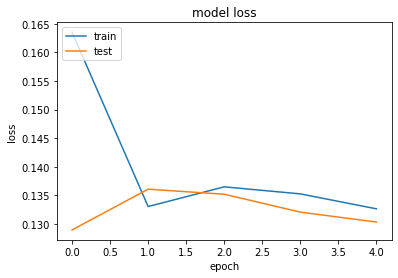

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/enunez/collab_filtering/ncf_model_20200915/assets
Training time: 1.1293291466765933 hours.
Training time: 1.1293296193414264 hours.


In [16]:
num_users, num_items = df.user.unique().shape[0], df.item.unique().shape[0]
embedding_size = 200
batch_size = 128
epoch = 5

t0 = time.time()
model = ncf.train(num_users=num_users, num_items=num_items, batch_size=batch_size, epochs=epoch)
print(f'Training time: {(time.time() - t0)/3600} hours.')

In [ ]:
csv_path = 'dataset/spot_scid_slug_20200301-20200831_reduced.csv'
ncf.recommend(csv_path, model, 'dataset/encodings.json', df.summit_client_id[400])

# Reload Model

In [20]:
csv_path = 'dataset/spot_scid_slug_20200301-20200831_reduced.csv'
cols = ['summit_client_id', 'slug', 'time_on_page']
ncf = NeuralCollabFiltering(cols)

In [24]:
import tensorflow as tf

load_model = tf.keras.models.load_model('ncf_model_20200915', custom_objects=None, compile=True, options=None
)

In [ ]:
recommendations = ncf.recommend(csv_path, load_model, 'dataset/encodings.json', user_id='u793kroVrYZM4ET1hpladd0A', verbose=False)
recommendations